# 911 Calls in Montgomery County, PA

This short project goes through simple analysis of the reported 911 calls located in Montgomery County, PA. The data is provided by [montcoalert.org](montcoalert.org) and was compiled here on [Kaggle](https://www.kaggle.com/mchirico/montcoalert) by a user named Mike Chirico. It is updated every so often. This notebook uses Version 50.

In [1]:
# first step is to import the necessary libraries for analysis.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# as our data is a csv file, we use the Pandas .read_csv function to assign it to the variable df as a DataFrame.
df = pd.read_csv('data/911-Update.csv')

The next couple lines of code is to briefly get an overview of the data-set as is without making adjustments.

In [3]:
# this function allows us to see the column names, amount of entries per column, and types of data in each column.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423909 entries, 0 to 423908
Data columns (total 9 columns):
lat          423909 non-null float64
lng          423909 non-null float64
desc         423909 non-null object
zip          371780 non-null float64
title        423909 non-null object
timeStamp    423909 non-null object
twp          423750 non-null object
addr         423909 non-null object
e            423909 non-null int64
dtypes: float64(3), int64(1), object(5)
memory usage: 29.1+ MB


In [4]:
# this function provides a quick overview of the numerical columns in regards to mean, standard deviation,
# and specific values such as min and max.
# judging by the column names, nothing of useful was immediately gained as latitude, longitude, zipcode, and Hour/Month were not
# typical numerical values such as price, test scores, etc.
df.describe()

,lat,lng,zip,e
count,423909.000000,423909.000000,371780.000000,423909.0
mean,40.158618,-75.314022,19234.732269,1.0
std,0.129170,0.656048,301.388898,0.0
min,0.000000,-119.698206,3366.000000,1.0
25%,40.099784,-75.391547,19038.000000,1.0
50%,40.143900,-75.304563,19401.000000,1.0
75%,40.229008,-75.210760,19446.000000,1.0
max,51.335390,87.854975,77316.000000,1.0


In [5]:
# the .head function allows us to see the first few rows of the DataFrame to get a feel of what is included at a glance
df.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


In [6]:
# we group the data by zipcode to see how many 911 calls are per zip code. the .head function again lets us see the first few.
df['zip'].value_counts().head()

19401.0    28656
19464.0    27948
19403.0    21631
19446.0    20496
19406.0    14097
Name: zip, dtype: int64

In [7]:
# we do the samething to towns
df['twp'].value_counts().head()

LOWER MERION    36441
ABINGTON        25835
NORRISTOWN      23883
UPPER MERION    22694
CHELTENHAM      19629
Name: twp, dtype: int64

In [8]:
# the title column is interesting because there is a reason followed by specifics. "reason:specifics"
# we check to see how many unique titles are in the data
df['title'].nunique()

141

In [9]:
# because it is a "reason:specifics" column, separating the reason from the specifics provides us with additional information.
df['reason'] = df['title'].apply(lambda title: title.split(':')[0])
df['specifics'] = df['title'].apply(lambda title: title.split(':')[1])

# now we can check the amount grouped by the different types of reasons.
df['reason'].value_counts()

EMS        208676
Traffic    151458
Fire        63775
Name: reason, dtype: int64

In [10]:
# we also check the different types of specifics. 
df['specifics'].value_counts()

 VEHICLE ACCIDENT -              98401
 DISABLED VEHICLE -              31871
 FIRE ALARM                      24459
 VEHICLE ACCIDENT                24081
 FALL VICTIM                     21258
 RESPIRATORY EMERGENCY           21159
 CARDIAC EMERGENCY               20620
 ROAD OBSTRUCTION -              14134
 SUBJECT IN PAIN                 12004
 HEAD INJURY                     11105
 UNKNOWN MEDICAL EMERGENCY        7171
 SYNCOPAL EPISODE                 7087
 GENERAL WEAKNESS                 7070
 SEIZURES                         6946
 ALTERED MENTAL STATUS            6184
 FIRE INVESTIGATION               6036
 MEDICAL ALERT ALARM              6022
 ABDOMINAL PAINS                  5802
 UNCONSCIOUS SUBJECT              5374
 HEMORRHAGING                     5264
 OVERDOSE                         5242
 CVA/STROKE                       5234
 NAUSEA/VOMITING                  4920
 GAS-ODOR/LEAK                    4468
 HAZARDOUS ROAD CONDITIONS -      4395
 CARDIAC ARREST          

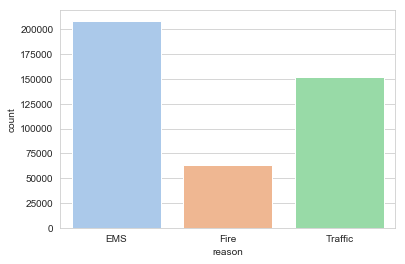

In [11]:
# the amount of reasons is something we can visually express so we plot it with Seaborn.
# the amount of specifics can also be plotted, but as there are 92 unique specifics, we will keep that on hold until we clean it.

sns.set_style('whitegrid')
sns.countplot(x='reason', data=df, palette="pastel")

## Time
The next step I took is looking at each reason per time period. In this case, we separate the timeStamp column and create three different columns: hours, months, and days. This allows us to look at each time period separately to see variation throughout.

In [12]:
# first check the data type
type(df['timeStamp'].iloc[0])

str

In [13]:
# next we separate the column into 3 new columns as previously mentioned
df['timeStamp'] = pd.to_datetime(df['timeStamp'])
df['Hour'] = df['timeStamp'].apply(lambda time: time.hour)
df['Month'] = df['timeStamp'].apply(lambda time: time.month)
df['Day of Week'] = df['timeStamp'].apply(lambda time: time.dayofweek)

In [14]:
# we then map the day to the number generated so the day of the week column shows day names instead of numbers
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['Day of Week'] = df['Day of Week'].map(dmap)

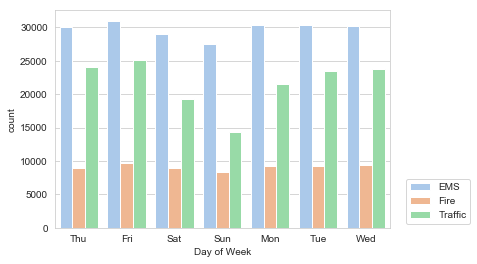

In [15]:
# we then plot it using our new day of the week column to see how the three reasons stack up on each day
sns.set_style('whitegrid')
sns.countplot(x='Day of Week',data=df,hue='reason',palette='pastel')

plt.legend(bbox_to_anchor=(1.05, 0.225), loc=2, borderaxespad=0.)

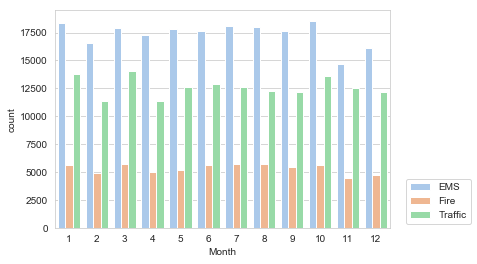

In [16]:
# I wanted to see if there were any large differences throughout the months as well
sns.countplot(x='Month',data=df,hue='reason',palette='pastel')

plt.legend(bbox_to_anchor=(1.05, 0.225), loc=2, borderaxespad=0.)

It looks like what we would expect, both a week and a month have generally the same ranking of reason types!

In [17]:
# next, I wanted to be more specific in regards to location so I opted to pick a town and Abington sounded cool so yeah!

dfabington = df.loc[df['twp'] == 'ABINGTON']
dfabington.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e,reason,specifics,Hour,Month,Day of Week
93,40.083078,-75.101117,SHELMIRE ST & CEDAR RD; ABINGTON; 2015-12-10 @...,19027.0,Traffic: DISABLED VEHICLE -,2015-12-10 21:47:14,ABINGTON,SHELMIRE ST & CEDAR RD,1,Traffic,DISABLED VEHICLE -,21,12,Thu
122,40.118594,-75.162653,PENN AVE & GARFIELD AVE; ABINGTON; Station 38...,19038.0,EMS: DIZZINESS,2015-12-11 02:10:29,ABINGTON,PENN AVE & GARFIELD AVE,1,EMS,DIZZINESS,2,12,Fri
126,40.107400,-75.113206,THE FAIRWAY & RYDAL RD; ABINGTON; Station 38...,19046.0,EMS: RESPIRATORY EMERGENCY,2015-12-11 03:09:08,ABINGTON,THE FAIRWAY & RYDAL RD,1,EMS,RESPIRATORY EMERGENCY,3,12,Fri
162,40.107400,-75.113206,THE FAIRWAY & RYDAL RD; ABINGTON; Station 38...,19046.0,EMS: HEMORRHAGING,2015-12-11 07:31:07,ABINGTON,THE FAIRWAY & RYDAL RD,1,EMS,HEMORRHAGING,7,12,Fri
167,40.121176,-75.133361,SUSQUEHANNA RD & EASTON RD; ABINGTON; 2015-12-...,19001.0,Traffic: VEHICLE ACCIDENT -,2015-12-11 08:04:24,ABINGTON,SUSQUEHANNA RD & EASTON RD,1,Traffic,VEHICLE ACCIDENT -,8,12,Fri


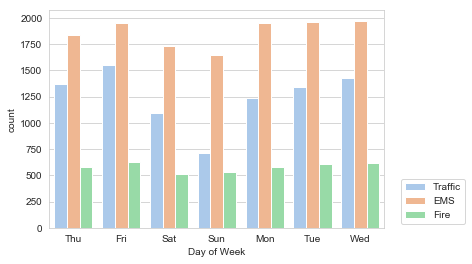

In [18]:
# we do the same steps in terms of visualizing the different amounts per reason but this time only for Abington
# first is a week chart, followed by a year chart
sns.countplot(x='Day of Week',data=dfabington,hue='reason',palette='pastel')

plt.legend(bbox_to_anchor=(1.05, 0.225), loc=2, borderaxespad=0.)

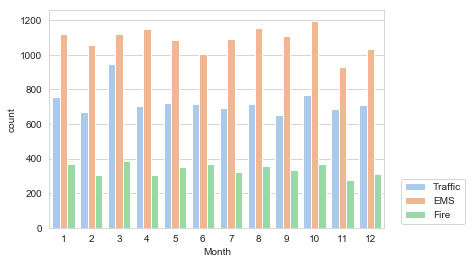

In [19]:
sns.countplot(x='Month',data=dfabington,hue='reason',palette='pastel')

plt.legend(bbox_to_anchor=(1.05, 0.225), loc=2, borderaxespad=0.)

In [20]:
# a heat map is another useful visualization tool to see the frequency!

dayHourab = dfabington.groupby(by=['Day of Week','Hour']).count()['reason'].unstack()
dayHourab.head()

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Day of Week,,,,,,,,,,,,,,,,,,,,,
Fri,65,43,53,49,48,66,77,150,225,214,...,294,306,310,287,251,237,145,160,119,100
Mon,59,46,45,58,58,64,95,146,207,203,...,221,251,236,264,226,193,143,124,105,76
Sat,75,67,55,49,59,52,70,87,117,177,...,196,219,220,220,209,190,154,131,102,96
Sun,70,69,64,44,49,47,59,119,121,154,...,190,168,183,162,171,173,115,97,83,82
Thu,57,54,49,47,39,70,72,152,201,234,...,245,275,227,239,225,151,154,137,77,75


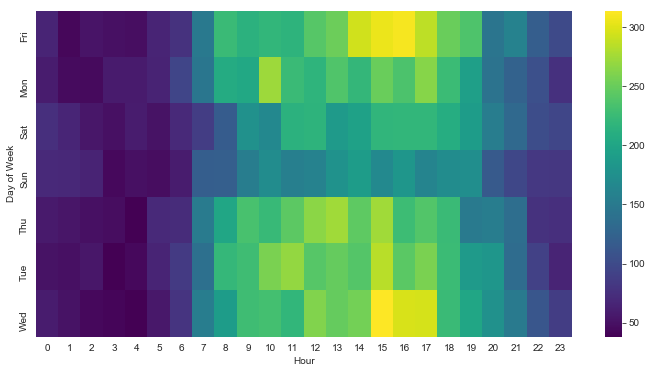

In [21]:
plt.figure(figsize=(12,6))
sns.heatmap(dayHourab,cmap='viridis')

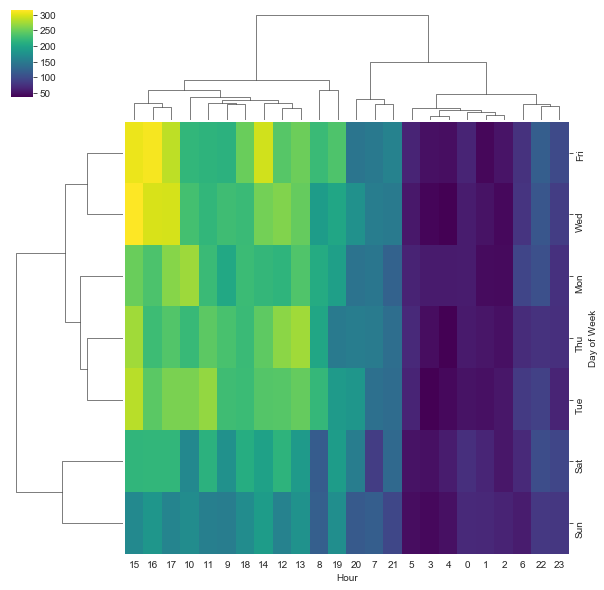

In [22]:
sns.clustermap(dayHourab,cmap='viridis')

This concludes the brief analysis of 911 calls in Montgomery County, PA. More specifically, in the town of Abington. There is more to be learned with more analysis.

The next step would be visualizing this data in Tableau.

# [Tableau Visualization](https://public.tableau.com/profile/jediah.j.pimentel#!/vizhome/911CallAbingtonVisualization/Dashboard1)

In the above Tableau visualization, I will only be looking strictly at Abington. But first, we save our new dataframe to a new csv file using the built in pandas function. 

In [23]:
dfabington.to_csv('data/911-Update-Abington.csv')

This dashboard allows us to select a specific and see the amounts per day / month for each specific. 

## Thank you!